## 컴퓨터를 사용하여 베이지언 추론하기

### 예제: 문자 메시지 데이터에서 행동 추론하기

In [25]:
# load library
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

(0.0, 74.0)

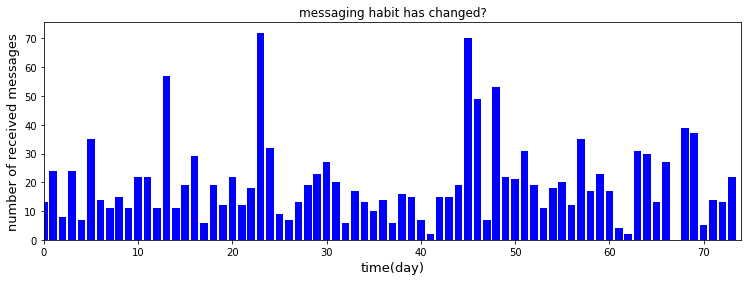

In [26]:
# load data and plot exploratory data
count_data = np.loadtxt(r"data/txtdata.csv")
n_count_data = len(count_data)
idx = np.arange(n_count_data)

plt.figure(figsize=(12.5, 4))
plt.bar(idx, count_data, color = "b")
plt.xlabel("time(day)", fontsize = 13)
plt.ylabel("number of received messages", fontsize =13)
plt.title("messaging habit has changed?")
plt.xlim(0, n_count_data)

* 특정 일자 i의 메시지 개수를 $C_{i}$ 로 표기할 경우, 메시지가 포아송 분포를 따른다고 가정한다면 다음과 같은 수식을 만족한다.

$$C_{i} \sim Poi(\lambda)$$

* 만약 어느 시점에서 메시지가 증가한다면 모수 $\lambda$가 증가했다고 가정해야 한다. 그러면 모수는 $\lambda_{1}$과 $\lambda_{2}$ 두개가 된다. 변하는 시점을 $\tau$라고 할 때, 이 시점을 변환점(switching point)라고 한다. 

$$ \lambda = \left \{
    \begin{array}{l} \lambda_{1} \; \textrm{if} \; t<\tau\\
    \lambda_{2} \; \textrm{if} \; t\geq\tau
     \end{array}\right.$$ 

* 베이지언 입장에서 $\lambda_{1}$과 $\lambda_{2}$에 대한 사전확률분포를 설정해야 할 필요가 있다. 책의 저자가 추천하는 방법은 지수분포다.

$$ \lambda_{1} \sim \textrm{Exp}(\alpha) \\
   \lambda_{2} \sim \textrm{Exp}(\alpha) $$
   
* 여기서 $\alpha$를 초모수(hyperparameter) 또는 부모변수(parent variable)이라고 말한다. 저자는 $\alpha$를 전체 메시지 수신 평균의 역수가 되도록 설정하길 권한다. 

* $\tau$에 대해서는 70일 동안 변화할 수 있는 확률이 일정하다는 가정하에, uniform distibution을 설정할 것을 권한다. 즉 1일부터 70일까지 매일 $\frac{1}{70}$의 확률로 Switching될 수 있다는 것이다. 

In [27]:
import pymc3 as pm

with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

print("Random output:", tau.random(), lambda_1.random(), lambda_2.random())

Random output: 20 23.99515988999556 6.691163084242409


In [28]:
with model:
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2) # switching lambda at tau
    observation = pm.Poisson("obs", lambda_, observed = count_data)
    step = pm.Metropolis()
    trace = pm.sample(10000, tune = 5000, step = step)

/tmp/ipykernel_279306/3387819497.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, tune = 5000, step = step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [29]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

Text(0, 0.5, 'probability')

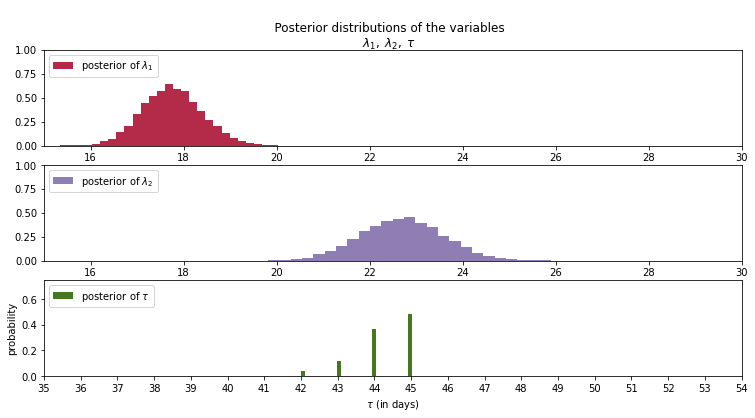

In [54]:
fig, ax = plt.subplots(3, 1, sharex= False, sharey=False, constrained_layout=False)
fig.set_size_inches((12.5, 6))

ax[0].hist(lambda_1_samples, histtype='stepfilled', bins = 30, alpha = 0.85, 
    label = r'posterior of $\lambda_{1}$', color = "#A60628", density=True)
ax[0].legend(loc="upper left")
fig.suptitle(r'''
    Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$
    ''')
ax[0].set_xlim([15, 30])
ax[0].set_ylim([0,1])
ax[0].set_xlabel("$\lambda_1$ value")


ax[1].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
ax[1].legend(loc="upper left")
ax[1].set_xlim([15, 30])
ax[1].set_ylim([0,1])
ax[1].set_xlabel("$\lambda_2$ value")


w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
ax[2].hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
ax[2].set_xticks(np.arange(n_count_data))

ax[2].legend(loc="upper left")
ax[2].set_ylim([0, .75])
ax[2].set_xlim([35, len(count_data)-20])
ax[2].set_xlabel(r"$\tau$ (in days)")
ax[2].set_ylabel("probability")